In [1]:
from getpass import getuser  # Libaray to copy things
from pathlib import Path  # Object oriented libary to deal with paths
from tempfile import (
    NamedTemporaryFile,
    TemporaryDirectory,
)  # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import (
    Client,
    progress,
    wait,
)  # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster  # Setting up distributed memories via slurm
import numpy as np  # Pythons standard array library
import xarray as xr  # Libary to work with labeled n-dimensional data
import dask  # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import sys
import os
import warnings

warnings.filterwarnings(action="ignore")
import pandas as pd

# dask.config.config.get("distributed").get("dashboard").update(
#     {"link": "{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status"}
# )

In [2]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 2
threads = ncpu // nworker
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}"
)
client = Client(
    processes=processes,
    threads_per_worker=threads,
    n_workers=nworker,
    memory_limit="128GB",
)
client

Number of CPUs: 256, number of threads: 128, number of workers: 2, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://136.172.124.3:8787/status,
Dashboard: http://136.172.124.3:8787/status,Workers: 2
Total threads: 256,Total memory: 238.42 GiB
Status: running,Using processes: False
Comm: inproc://136.172.124.3/107143/1,Workers: 2
Dashboard: http://136.172.124.3:8787/status,Total threads: 256
Started: Just now,Total memory: 238.42 GiB
Comm: inproc://136.172.124.3/107143/4,Total threads: 128
Dashboard: http://136.172.124.3:46295/status,Memory: 119.21 GiB
Nanny: None,


In [3]:
# Define a global pattern to find the files
###cloud liquid water
glob_pattern_3d1 = "atm_2d_ml_2020"
## Define the paths of file 1 (dppp0016)
data_path1 = Path("/work/mh0287/k203123/Dyamond++/icon-aes-dyw2/experiments/dpp0029")
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water
file_names1 = sorted([str(f) for f in data_path1.rglob(f"*{glob_pattern_3d1}*.nc")])[:]

In [4]:
file_names1[0]

'/work/mh0287/k203123/Dyamond++/icon-aes-dyw2/experiments/dpp0029/dpp0029_atm_2d_ml_20200120T000000Z.nc'

In [5]:
a = xr.open_dataset('/work/mh0287/k203123/Dyamond++/icon-aes-dyw2/experiments/dpp0029/dpp0029_atm_2d_ml_20201231T000000Z.nc')
a

ERROR 1: PROJ: proj_create_from_database: Open of /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/share/proj failed


<xarray.Dataset>
Dimensions:  (time: 1, ncells: 20971520)
Coordinates:
  * time     (time) float64 2.02e+07
Dimensions without coordinates: ncells
Data variables: (12/36)
    ps       (time, ncells) float32 ...
    psl      (time, ncells) float32 ...
    rsdt     (time, ncells) float32 ...
    rsut     (time, ncells) float32 ...
    rsutcs   (time, ncells) float32 ...
    rlut     (time, ncells) float32 ...
    ...       ...
    tauu     (time, ncells) float32 ...
    tauv     (time, ncells) float32 ...
    sfcwind  (time, ncells) float32 ...
    uas      (time, ncells) float32 ...
    vas      (time, ncells) float32 ...
    tas      (time, ncells) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  15
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9
    title:                ICON simulation
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@add96e8c60ea3f...
    history:              /work/mh0287/k203123/GIT/icon-aes-dyw2/bin/icon_dpp...
    references:           see MPIM/DWD publications
    comment:              Sapphire Dyamond (k203123) on m21233 (Linux 2.6.32-...

In [6]:
print(len(file_names1))

343


In [7]:
dset1 = xr.open_mfdataset(
    file_names1[0:100], combine="by_coords", chunks="auto", engine="netcdf4", parallel=True
)

In [8]:
dset1.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (time: 223, ncells: 20971520)
Coordinates:
  * time     (time) float64 2.02e+07 2.02e+07 2.02e+07 ... 2.02e+07 2.02e+07
Dimensions without coordinates: ncells
Data variables: (12/36)
    ps       (time, ncells) float32 dask.array<chunksize=(2, 16777214), meta=np.ndarray>
    psl      (time, ncells) float32 dask.array<chunksize=(2, 16777214), meta=np.ndarray>
    rsdt     (time, ncells) float32 dask.array<chunksize=(2, 16777214), meta=np.ndarray>
    rsut     (time, ncells) float32 dask.array<chunksize=(2, 16777214), meta=np.ndarray>
    rsutcs   (time, ncells) float32 dask.array<chunksize=(2, 16777214), meta=np.ndarray>
    rlut     (time, ncells) float32 dask.array<chunksize=(2, 16777214), meta=np.ndarray>
    ...       ...
    tauu     (time, ncells) float32 dask.array<chunksize=(2, 16777214), meta=np.ndarray>
    tauv     (time, ncells) float32 dask.array<chunksize=(2, 16777214), meta=np.ndarray>
    sfcwind  (time, ncells)

In [9]:
format_bytes(dset1.nbytes)

'627.19 GiB'

In [10]:
pr_data = dset1["pr"]
pr_data

<xarray.DataArray 'pr' (time: 223, ncells: 20971520)>
dask.array<concatenate, shape=(223, 20971520), dtype=float32, chunksize=(2, 16777214), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.02e+07 2.02e+07 2.02e+07 ... 2.02e+07 2.02e+07
Dimensions without coordinates: ncells
Attributes:
    standard_name:                pr
    long_name:                    precipitation flux
    units:                        kg m-2 s-1
    param:                        52.1.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [11]:
time1 = pd.to_datetime(pr_data.time.data, format="%Y%m%d")
hours = (pr_data.time.values % 1) * 24
time2 = pd.to_datetime(hours, format="%H")
timenew = pd.to_datetime(pd.to_numeric(time2 - time2[0]) + pd.to_numeric(time1))

In [12]:
pr_data["time"] = timenew

In [13]:
pr_data.time

<xarray.DataArray 'time' (time: 223)>
array(['2020-01-20T00:00:00.000000000', '2020-01-20T06:00:00.000000000',
       '2020-01-20T12:00:00.000000000', ..., '2020-04-26T00:00:00.000000000',
       '2020-04-27T00:00:00.000000000', '2020-04-28T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T06:00:00 ... 2020-04-28

In [14]:
pr_data.time[0:5] # 6 hourly

<xarray.DataArray 'time' (time: 5)>
array(['2020-01-20T00:00:00.000000000', '2020-01-20T06:00:00.000000000',
       '2020-01-20T12:00:00.000000000', '2020-01-20T18:00:00.000000000',
       '2020-01-21T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T06:00:00 ... 2020-01-21

In [15]:
pr_daily = (
    pr_data.sel(time=slice("2020-02-10", "2020-03-10"))
    .resample(time="1D", skipna=True)
    .mean()
)

In [16]:
pr_daily

<xarray.DataArray 'pr' (time: 30, ncells: 20971520)>
dask.array<stack, shape=(30, 20971520), dtype=float32, chunksize=(1, 16777214), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-02-10 2020-02-11 ... 2020-03-10
Dimensions without coordinates: ncells
Attributes:
    standard_name:                pr
    long_name:                    precipitation flux
    units:                        kg m-2 s-1
    param:                        52.1.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [17]:
####grid information
filegrid = "/pool/data/ICON/grids/public/mpim/0015/icon_grid_0015_R02B09_G.nc"
dsetgrid = xr.open_dataset(filegrid, chunks="auto", engine="netcdf4").rename(
    {"cell": "ncells"}
)

In [18]:
dsetgrid

<xarray.Dataset>
Dimensions:                         (ncells: 20971520, nv: 3, vertex: 10485762,
                                     ne: 6, edge: 31457280, no: 4, nc: 2,
                                     max_stored_decompositions: 4, two_grf: 2,
                                     cell_grf: 14, max_chdom: 1, edge_grf: 24,
                                     vert_grf: 13)
Coordinates:
    clon                            (ncells) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    clat                            (ncells) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    vlon                            (vertex) float64 dask.array<chunksize=(10485762,), meta=np.ndarray>
    vlat                            (vertex) float64 dask.array<chunksize=(10485762,), meta=np.ndarray>
    elon                            (edge) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    elat                            (edge) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
Dimensions without coordinates: ncells, nv, vertex, ne, edge, no, nc,
                                max_stored_decompositions, two_grf, cell_grf,
                                max_chdom, edge_grf, vert_grf
Data variables: (12/91)
    clon_vertices                   (ncells, nv) float64 dask.array<chunksize=(16777214, 1), meta=np.ndarray>
    clat_vertices                   (ncells, nv) float64 dask.array<chunksize=(16777214, 1), meta=np.ndarray>
    vlon_vertices                   (vertex, ne) float64 dask.array<chunksize=(5592404, 3), meta=np.ndarray>
    vlat_vertices                   (vertex, ne) float64 dask.array<chunksize=(5592404, 3), meta=np.ndarray>
    elon_vertices                   (edge, no) float64 dask.array<chunksize=(16777214, 1), meta=np.ndarray>
    elat_vertices                   (edge, no) float64 dask.array<chunksize=(16777214, 1), meta=np.ndarray>
    ...                              ...
    edge_dual_normal_cartesian_x    (edge) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    edge_dual_normal_cartesian_y    (edge) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    edge_dual_normal_cartesian_z    (edge) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    cell_circumcenter_cartesian_x   (ncells) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    cell_circumcenter_cartesian_y   (ncells) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    cell_circumcenter_cartesian_z   (ncells) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
Attributes: (12/43)
    title:                    ICON grid description
    institution:              Max Planck Institute for Meteorology/Deutscher ...
    source:                   git@git.mpimet.mpg.de:GridGenerator.git
    revision:                 d00fcac1f61fa16c686bfe51d1d8eddd09296cb5
    date:                     20180529 at 222250
    user_name:                Rene Redler (m300083)
    ...                       ...
    topography:               modified SRTM30
    subcentre:                1
    number_of_grid_used:      15
    history:                  Thu Aug 16 11:05:44 2018: ncatted -O -a ICON_gr...
    ICON_grid_file_uri:       http://icon-downloads.mpimet.mpg.de/grids/publi...
    NCO:                      netCDF Operators version 4.7.5 (Homepage = http...

In [19]:
pr_mean = pr_daily.mean(dim="time").compute()

In [20]:
pr_mean

<xarray.DataArray 'pr' (ncells: 20971520)>
array([1.3562195e-05, 1.3487518e-05, 1.3580961e-05, ..., 3.3366538e-05,
       3.4132456e-05, 3.4461165e-05], dtype=float32)
Dimensions without coordinates: ncells

In [21]:
format_bytes(pr_mean.nbytes)

'80.00 MiB'

In [22]:
pr_mean = pr_mean.assign_coords(
    clon=("ncells", dsetgrid.clon.data * 180 / np.pi),
    clat=("ncells", dsetgrid.clat.data * 180 / np.pi),
)

In [23]:
pr_mean

<xarray.DataArray 'pr' (ncells: 20971520)>
array([1.3562195e-05, 1.3487518e-05, 1.3580961e-05, ..., 3.3366538e-05,
       3.4132456e-05, 3.4461165e-05], dtype=float32)
Coordinates:
    clon     (ncells) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    clat     (ncells) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
Dimensions without coordinates: ncells

In [24]:
from cartopy import crs as ccrs  # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib import pyplot as plt  # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [25]:
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
# cs1 = plt.scatter(
#     pr_mean.clon[::100],
#     pr_mean.clat[::100],
#     s=0.1,
#     c=pr_mean[::100] * 24 * 3600,
#     vmin=0,
#     vmax=14,
#     cmap="YlGnBu",
#     transform=ccrs.PlateCarree(),
# )
# cb1 = plt.colorbar(cs1, extend="max", orientation="horizontal", shrink=0.6, pad=0.1)
# cb1.ax.set_xlabel("Precipitation (mm day$^{-1}$)", fontsize=12)
# cb1.ax.tick_params(labelsize=12)
# ax.coastlines(resolution="110m", linewidth=0.6)
# ax.set_extent([-180, 179.9, -80, 80], crs=ccrs.PlateCarree())
# ax.set_yticks(np.arange(-80, 81, 20), crs=ccrs.PlateCarree())
# lat_formatter = LatitudeFormatter()
# ax.yaxis.set_major_formatter(lat_formatter)
# ax.set_xticks(np.arange(-180, 179, 60), crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.tick_params(labelsize=12)
# ax.set_xlabel(None)
# ax.set_ylabel(None)

In [26]:
def get_griddes(y_res, x_res, x_first=-180, y_first=-90):
    """Create a description for a regular global grid at given x, y resolution."""

    xsize = 360 / x_res
    ysize = 180 / y_res
    xfirst = -180 + x_res / 2
    yfirst = -90 + x_res / 2

    return f"""
#
# gridID 1
#
gridtype  = lonlat
gridsize  = {int(xsize * ysize)}
xsize     = {int(xsize)}
ysize     = {int(ysize)}
xname     = lon
xlongname = "longitude"
xunits    = "degrees_east"
yname     = lat
ylongname = "latitude"
yunits    = "degrees_north"
xfirst    = {xfirst}
xinc      = {x_res}
yfirst    = {yfirst}
yinc      = {y_res}


    """

In [27]:
@dask.delayed
def gen_dis(dataset, xres, yres, gridfile):
    """Create a distance weights using cdo."""
    scratch_dir = (
        Path("/scratch") / getuser()[0] / getuser() / Path("data")
    )  # Define the users scratch dir
    with TemporaryDirectory(dir=scratch_dir, prefix="Weights_") as td:
        in_file = Path(td) / "in_file.nc"
        weightfile = Path(td) / "weight_file.nc"
        griddes = Path(td) / "griddes.txt"

        
        with griddes.open("w") as f:
            f.write(get_griddes(xres, yres))
        dataset.to_netcdf(in_file, mode="w")  # Write the file to a temorary netcdf file
        cmd = (
            "cdo",
            "-O",
            f"gendis,{griddes}",
            f"-setgrid,{gridfile}",
            str(in_file),
            str(weightfile),
        )
        run_cmd(cmd)
        df = xr.open_dataset(weightfile).load()
        wait(df)
        return df


def run_cmd(cmd, path_extra=Path(sys.exec_prefix) / "bin"):
    """Run a bash command."""
    env_extra = os.environ.copy()
    env_extra["PATH"] = str(path_extra) + ":" + env_extra["PATH"]
    status = run(cmd, check=False, stderr=PIPE, stdout=PIPE, env=env_extra)
    if status.returncode != 0:
        error = f"""{' '.join(cmd)}: {status.stderr.decode('utf-8')}"""
        raise RuntimeError(f"{error}")
    return status.stdout.decode("utf-8")

In [28]:
@dask.delayed
def remap(dataset, x_res, y_res, weights, gridfile):
    """Perform a weighted remapping.

    Parameters
    ==========

    dataset : xarray.dataset
        The dataset that will be regridded
    griddes : Path, str
        Path to the grid description file
    weights : xarray.dataset
        Distance weights

    Returns
    =======
    xarray.dataset : Remapped dataset
    """
    if isinstance(dataset, xr.DataArray):
        # If a dataArray is given create a dataset
        dataset = xr.Dataset(data_vars={dataset.name: dataset})
    scratch_dir = (
        Path("/scratch") / getuser()[0] / getuser() / Path("data")
    )  # Define the users scratch dir
    with TemporaryDirectory(dir=scratch_dir, prefix="Remap_") as td:
        infile = Path(td) / "input_file.nc"
        weightfile = Path(td) / "weight_file.nc"
        griddes = Path(td) / "griddes.txt"
        outfile = Path(td) / "remaped_file.nc"
        with griddes.open("w") as f:
            f.write(get_griddes(x_res, y_res))
        dataset.to_netcdf(infile, mode="w")  # Write the file to a temorary netcdf file
        weights.to_netcdf(weightfile, mode="w")
        cmd = (
            "cdo",
            "-O",
            f"remap,{griddes},{weightfile}",
            f"-setgrid,{gridfile}",
            str(infile),
            str(outfile),
        )
        run_cmd(cmd)
        return xr.open_dataset(outfile).load()

In [29]:
pr_mean

<xarray.DataArray 'pr' (ncells: 20971520)>
array([1.3562195e-05, 1.3487518e-05, 1.3580961e-05, ..., 3.3366538e-05,
       3.4132456e-05, 3.4461165e-05], dtype=float32)
Coordinates:
    clon     (ncells) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    clat     (ncells) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
Dimensions without coordinates: ncells

In [30]:
weights_future = gen_dis(pr_mean, 0.1, 0.1, filegrid)

In [31]:
####File 1
remap_precip = remap(pr_mean, 0.1, 0.1, weights_future, filegrid)

In [32]:
remap_jobs = dask.persist(remap_precip)

In [33]:
progress(remap_jobs, notebook=False)

In [34]:
precip = dask.compute(remap_precip)[0]

In [35]:
precip.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1800)
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    pr       (lat, lon) float32 1.695e-06 1.695e-06 ... 5.842e-06 5.842e-06
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Dec 19 04:48:07 2023: cdo -O remap,/scratch/b/b382628/d...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...>

Text(0, 0.5, '')

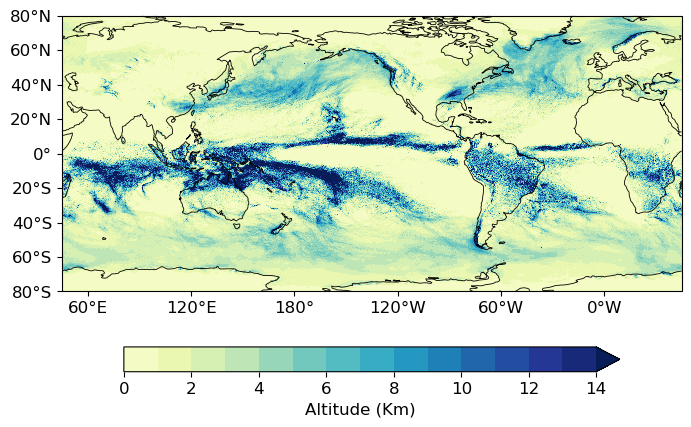

In [37]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=225))
plot = (precip.pr * 24 * 3600).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="YlGnBu",
    levels=np.linspace(0, 14, 15),
    vmin=0,
    vmax=14,
    extend="both",
    add_colorbar=False,
)
cb1 = plt.colorbar(plot, extend="max", orientation="horizontal", shrink=0.8, pad=0.12)
cb1.ax.set_xlabel("Altitude (Km)", fontsize=12)
cb1.ax.tick_params(labelsize=12)
ax.coastlines(resolution="110m", linewidth=0.6)
ax.set_extent([-180, 179.9, -80, 80], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-80, 81, 20), crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-180, 179, 60), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
ax.set_xlabel(None)
ax.set_ylabel(None)

In [36]:
scratch_dir = (
    Path("/scratch") / getuser()[0] / getuser()
)  # if it has not been defined before
out_file = Path(scratch_dir) / "OutfileName.nc"
pr_mean.to_netcdf(out_file, mode="w")

2023-12-19 04:48:10,305 - distributed.worker - WARNING - Compute Failed
Key:       ('truediv-store-map-34a9f3d19b99e7a8f3c13045ad85bba3', 1)
Function:  execute_task
args:      ((<function store_chunk at 0x7fa11853eb90>, (subgraph_callable-871f2a1a-d286-4f54-ba21-32bd7f8cd765, 3.141592653589793, 180, ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x7fa05c11d080>, key=BasicIndexer((slice(None, None, None),))))), (slice(16777216, 20971520, None),)), <xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x7fa0bc3e4f40>, (slice(16777216, 20971520, None),), None, False))
kwargs:    {}
Exception: "ValueError('Lock is not yet acquired')"



ValueError: Lock is not yet acquired

In [ ]:
loadset = xr.open_dataset(out_file, chunks="auto", engine="netcdf4")

In [ ]:
loadset.info

In [ ]:
getuser()[0]

'b'

In [ ]:
getuser()

'b382628'

In [ ]:
scratch_dir = (
    Path("/scratch") / getuser()[0] / getuser() / Path("data")
)  # Define the users scratch dir

In [ ]:
scratch_dir

PosixPath('/scratch/b/b382628/data')

In [ ]:
# @dask.delayed
def gen_dis(dataset, xres, yres, gridfile):
    """Create a distance weights using cdo."""
    scratch_dir = (
        Path("/scratch") / getuser()[0] / getuser() / Path("data")
    )  # Define the users scratch dir
    with TemporaryDirectory(dir=scratch_dir, prefix="Weights_") as td:
        in_file = Path(td) / "in_file.nc"
        weightfile = Path(td) / "weight_file.nc"
        griddes = Path(td) / "griddes.txt"

        print(f"Temporary in_file path: {in_file}")
        print(f"Temporary weightfile path: {weightfile}")
        print(f"Temporary griddes path: {griddes}")

        # Additional code for writing files...
        # ...

        # Debugging: Check if files exist
        if in_file.exists():
            print(f"in_file exists at {in_file}")
        else:
            print(f"in_file does not exist at {in_file}")

        if weightfile.exists():
            print(f"weightfile exists at {weightfile}")
        else:
            print(f"weightfile does not exist at {weightfile}")

        if griddes.exists():
            print(f"griddes exists at {griddes}")
        else:
            print(f"griddes does not exist at {griddes}")

        
        with griddes.open("w") as f:
            f.write(get_griddes(xres, yres))
        dataset.to_netcdf(in_file, mode="w")  # Write the file to a temorary netcdf file
        cmd = (
            "cdo",
            "-O",
            f"gendis,{griddes}",
            f"-setgrid,{gridfile}",
            str(in_file),
            str(weightfile),
        )
        run_cmd(cmd)
        df = xr.open_dataset(weightfile).load()
        wait(df)
        return df

In [ ]:
weights_future = gen_dis(pr_mean, 0.1, 0.1, filegrid)

Temporary in_file path: /scratch/b/b382628/data/Weights_xelssbuy/in_file.nc
Temporary weightfile path: /scratch/b/b382628/data/Weights_xelssbuy/weight_file.nc
Temporary griddes path: /scratch/b/b382628/data/Weights_xelssbuy/griddes.txt
in_file does not exist at /scratch/b/b382628/data/Weights_xelssbuy/in_file.nc
weightfile does not exist at /scratch/b/b382628/data/Weights_xelssbuy/weight_file.nc
griddes does not exist at /scratch/b/b382628/data/Weights_xelssbuy/griddes.txt


In [ ]:
weights_future

Delayed('gen_dis-61fcd566-b353-4e70-9ce4-c00c599683a5')